In [22]:

# --- 1. Requêtes Web & Système ---
import requests
import joblib

# --- 2. Manipulation de Données ---
import polars as pl

# --- 3. Visualisation ---
import matplotlib.pyplot as plt

# --- 4. Scikit-Learn : Outils de base ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# --- 5. Le Modèle choisi ---
from sklearn.ensemble import RandomForestClassifier

# --- 6. AutoML ---
from lazypredict.Supervised import LazyClassifier


In [23]:
def get_lol_champions():
    #1 Récupération du dernier numéro de patch
    try:
        version_url = "https://ddragon.leagueoflegends.com/api/versions.json"
        latest_version = requests.get(version_url).json()[0]
        print(f"Chargement des données pour le patch : {latest_version}")
    except Exception as e:
        print(f"Erreur lors de la récupération de la version : {e}")
        return

    #2. Télécharger les données avec l'URL dynamique
    url = f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/champion.json"
    
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors du téléchargement des champions (Status: {response.status_code})")
        return

    data = response.json()
    champions_dict = data['data']

    #3. On chope les infos (Ta logique existante)
    rows = []
    for champ_name, details in champions_dict.items():
        stats = details['stats']
        info = details['info']
        
        rows.append({
            "Name": champ_name,
            "Class": details['tags'][0],  # Rôle principal
            "AttackRange": stats['attackrange'],
            "MoveSpeed": stats['movespeed'],

            "HP": stats['hp'],
            "HPperLevel": stats['hpperlevel'],

            "hpregen": stats['hpregen'],
            "hpregenperlevel": stats['hpregenperlevel'],

            "Armor": stats['armor'],
            "ArmorperLevel": stats['armorperlevel'],
            
            "AttackDamage": stats['attackdamage'],
            "AttackDamageperLevel": stats['attackdamageperlevel'],

            "attackspeed": stats['attackspeed'],
            "attackspeedperlevel": stats['attackspeedperlevel'],

            "Spellblock": stats['spellblock'],
            "spellblockperlevel": stats['spellblockperlevel'],

            "Prv_attack": info['attack'],
            "Prv_defense": info['defense'],
            "Prv_magic": info['magic']
        })

    #4. Créer le Tableau + Polars
    tableau_champ = pl.DataFrame(rows)
    
    

    # Affichage 
    pl.Config.set_tbl_rows(10) 
    print(tableau_champ)
    #suuuuuper important pour la suite sinon c'est ko
    return tableau_champ

if __name__ == "__main__":
    tableau_champ = get_lol_champions()

Chargement des données pour le patch : 16.2.1
shape: (172, 19)
┌─────────┬──────────┬────────────┬───────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Name    ┆ Class    ┆ AttackRang ┆ MoveSpeed ┆ … ┆ spellblock ┆ Prv_attac ┆ Prv_defen ┆ Prv_magic │
│ ---     ┆ ---      ┆ e          ┆ ---       ┆   ┆ perlevel   ┆ k         ┆ se        ┆ ---       │
│ str     ┆ str      ┆ ---        ┆ i64       ┆   ┆ ---        ┆ ---       ┆ ---       ┆ i64       │
│         ┆          ┆ i64        ┆           ┆   ┆ f64        ┆ i64       ┆ i64       ┆           │
╞═════════╪══════════╪════════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Aatrox  ┆ Fighter  ┆ 175        ┆ 345       ┆ … ┆ 2.05       ┆ 8         ┆ 4         ┆ 3         │
│ Ahri    ┆ Mage     ┆ 550        ┆ 330       ┆ … ┆ 1.3        ┆ 3         ┆ 4         ┆ 8         │
│ Akali   ┆ Assassin ┆ 125        ┆ 345       ┆ … ┆ 2.05       ┆ 5         ┆ 3         ┆ 8         │
│ Akshan  ┆ Marksman ┆ 500  

In [24]:
#Séparation
#1. On chope la liste des colonnes statistiques (les "Features")
# On vire "Name", "Class" et "Target"
features_cols = [
    col for col in tableau_champ.columns 
    if col not in ["Name", "Class", "Target","Prv_attack","Prv_defense","Prv_magic","spellblockperlevel","attackspeedperlevel","AttackDamageperLevel","ArmorperLevel","hpregenperlevel","HPperLevel"]
]

#2. On crée X à choper et y cibles
X = tableau_champ.select(features_cols)
y = tableau_champ.select("Class")

print(f"L'IA va s'entraîner sur {len(features_cols)} caractéristiques.")
print(f"Colonnes utilisées pour X : {features_cols}")
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y)
#

L'IA va s'entraîner sur 8 caractéristiques.
Colonnes utilisées pour X : ['AttackRange', 'MoveSpeed', 'HP', 'hpregen', 'Armor', 'AttackDamage', 'attackspeed', 'Spellblock']


In [25]:
reg = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)


models, predictions = reg.fit(
    X_tr.to_pandas(), 
    X_te.to_pandas(), 
    y_tr.to_pandas(), 
    y_te.to_pandas()
)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 8
[LightGBM] [Info] Start training from score -2.294863
[LightGBM] [Info] Start training from score -1.222226
[LightGBM] [Info] Start training from score -1.563976
[LightGBM] [Info] Start training from score -1.864080
[LightGBM] [Info] Start training from score -2.087224
[LightGBM] [Info] Start training from score -2.151762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

Enrgistremnt du modèle final 

In [ ]:
#1 prépa
features_cols = [
    col for col in tableau_champ.columns 
    if col not in ["Name", "Class", "Target"]
]

print(f"Features utilisées ({len(features_cols)}) : {features_cols}")

X = tableau_champ.select(features_cols)
y = tableau_champ.select("Class")

#2 je vais imiter les hyperpara de mes codes précédents
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced'
)

# 3. entraînement
print("Entraînement")
rf_model.fit(X, y)
print("tadaaaaam")

# Verification du score
print(f"Score sur l'entraînement: {rf_model.score(X, y):.2%}")

# 4. sauvegarde
package = {
    "pipeline": rf_model, 
    "features": features_cols, 
    "description": "Random Forest pour classification des champions"
}

filename = "lol_champ_model.pkl"
joblib.dump(package, filename)
print(f" Le fichier '{filename}' a été enregstré avec le Random Forest.")

Features utilisées (17) : ['AttackRange', 'MoveSpeed', 'HP', 'HPperLevel', 'hpregen', 'hpregenperlevel', 'Armor', 'ArmorperLevel', 'AttackDamage', 'AttackDamageperLevel', 'attackspeed', 'attackspeedperlevel', 'Spellblock', 'spellblockperlevel', 'Prv_attack', 'Prv_defense', 'Prv_magic']
Entraînement
tadaaaaam
Score sur l'entraînement: 94.77%
 Le fichier 'lol_champ_model.pkl' a été enregstré avec le Random Forest.


j'avais fait de la D

In [26]:
# 1. Création du modèle 
rf_model = RandomForestClassifier(
     n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced' # Aide pour les Assassins/Mages rares
)

# 2. Entraînement sur les données trt)
print(" Entraînement du Random Forest sur X_tr...")
rf_model.fit(X_tr, y_tr)
print(" Modèle entraîné !")

 Entraînement du Random Forest sur X_tr...
 Modèle entraîné !


Précision sur les données test : 69.77%
Rapport détaillé
              precision    recall  f1-score   support

    Assassin       0.67      0.67      0.67         3
     Fighter       0.71      0.83      0.77        12
        Mage       0.83      0.56      0.67         9
    Marksman       0.86      0.75      0.80         8
     Support       0.14      0.50      0.22         2
        Tank       1.00      0.67      0.80         9

    accuracy                           0.70        43
   macro avg       0.70      0.66      0.65        43
weighted avg       0.80      0.70      0.73        43



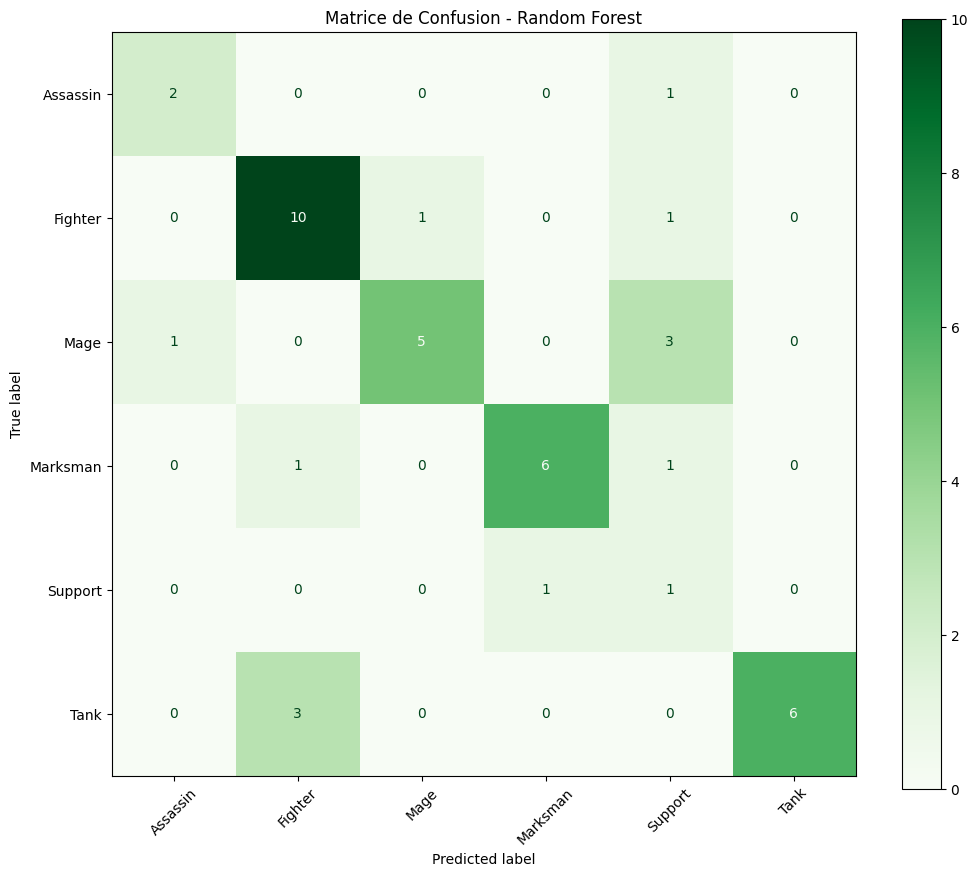

In [27]:
# 1. Calcul du score global
score_test = rf_model.score(X_te, y_te)
print(f"Précision sur les données test : {score_test:.2%}")

# 2. Rapport détaillé (Optionnel mais utile pour voir les stats par classe)
print("Rapport détaillé")
y_pred = rf_model.predict(X_te)
print(classification_report(y_te, y_pred))

# 3. Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(12, 10)) # Grande taille pour bien lire
ConfusionMatrixDisplay.from_estimator(
    rf_model, 
    X_te, 
    y_te, 
    ax=ax, 
    cmap="Greens", # Vert foret pour le Random Forest ;)
    xticks_rotation=45
)
plt.title("Matrice de Confusion - Random Forest")
plt.show()